# Encoder Smoothing least squares fit

In [1]:
import sympy
import numpy
import math
import io

import matplotlib.pyplot as plt

In [2]:
sympy.init_session()

IPython console for SymPy 1.12 (Python 3.11.4-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.12/



In [3]:
%matplotlib inline

In [4]:
plt.rcParams['figure.figsize'] = [12, 6]

In [5]:
def display_dict(d):
    """ Display a dict of variable: expression (eg. a result of solve)"""
    for v, expr in d.items():
        display(Eq(v, expr))

In [6]:
def factor_sums(expr):
    def cSum(s):
      con, dep = factor_terms(s.function.as_independent(*s.variables))
      return con*Sum(dep, *s.args[1:])

    return expr.expand().replace(lambda s: isinstance(s, Sum), lambda s: cSum(s))

In [7]:
dt = Symbol("Δt")
dt

In [8]:
var("a, v, x, p0, p1, p2, s_t, s_t2, s_t3, s_t4, s_y, s_yy, s_ty, s_t2y, s_iy, s_i2y, theta", real=True)

In [9]:
var("i, j, k", integer=True)

In [10]:
y = Function("y", real=True)

In [11]:
t = Function("t", real=True)

In [12]:
def interpolation_function(t):
    return p0 + p1 * t# + p2 * t**2

In [13]:
variables = [p0, p1, p2]

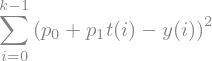

In [14]:
error = Sum((interpolation_function(t(i)) - y(i))**2, (i, 0, k-1))
error

In [15]:
#error = error.subs(y(i), (y(i) - y(i - 1)))
#error

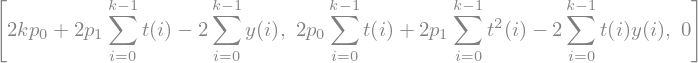

In [16]:
eqs = [factor_sums(diff(error, var)).doit() for var in variables]
eqs

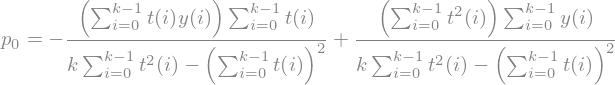

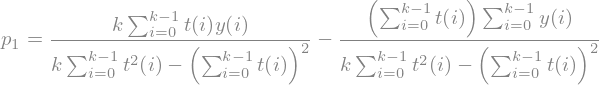

In [17]:
solution = solve(eqs, variables)
display_dict(solution)

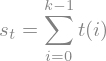

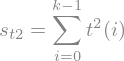

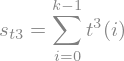

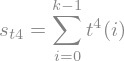

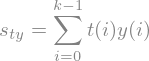

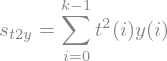

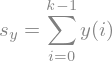

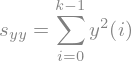

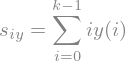

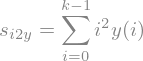

In [18]:
substitutions = { name: Sum(expr, (i, 0, k-1)) for (name, expr) in [
    (s_t, t(i)),
    (s_t2, t(i)**2),
    (s_t3, t(i)**3),
    (s_t4, t(i)**4),
    (s_ty, t(i) * y(i)),
    (s_t2y, t(i)**2 * y(i)),
    (s_y, y(i)),
    (s_yy, y(i)**2),
    (s_iy, i * y(i)),
    (s_i2y, i**2 * y(i)),
]}
display_dict(substitutions)

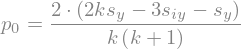

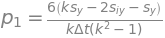

In [19]:
substituted_solution = {
    name: (
        expr
        .subs([
            (expr, substitution)
            for (substitution, expr)
            in substitutions.items()
        ])
        .simplify()
        .subs(substitutions)
        .replace(t, lambda i: -i * dt)
        .doit()
        .subs([
            (expr, substitution)
            for (substitution, expr)
            in substitutions.items()
        ])
        .simplify()
        .subs([
            (expr, substitution)
            for (substitution, expr)
            in substitutions.items()
        ])
        .simplify()
    )
    for (name, expr) in solution.items()
}
display_dict(substituted_solution)

In [20]:
def factor_subexpressions(expr, variable):
    expr = expr.collect(expr.free_symbols - {variable})
    if expr.free_symbols == {variable}:
        return expr.factor()
    elif len(expr.args) > 0:
        return expr.func(
            *[factor_subexpressions(arg, variable) for arg in expr.args]
        )
    else:
        return expr

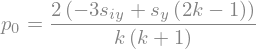

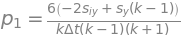

In [21]:
factored_solution = {
    var: factor_subexpressions(
        expr,
        k
    )
    for (var, expr)
    in substituted_solution.items()
}
display_dict(factored_solution)

## Condition for operation
We want to verify that during the operation the fitting error is small.

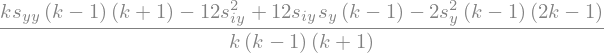

In [22]:
sum_of_squared_residuals = factor_subexpressions(
    factor_sums(
        Sum((interpolation_function(t(j)) - y(j))**2, (j, 0, k-1))
        .subs(solution)
        .replace(t, lambda i: -i * dt)
        .expand()
        .doit()
    )
    .subs([
        (expr, substitution)
        for (substitution, expr)
        in substitutions.items()
    ])
    .subs(Sum(j * y(j), (j, 0, k-1)), s_iy)
    .subs(Sum(y(j), (j, 0, k-1)), s_y)
    .subs(Sum(y(j)**2, (j, 0, k-1)), s_yy)
    .simplify(),
    k
)
display(sum_of_squared_residuals)

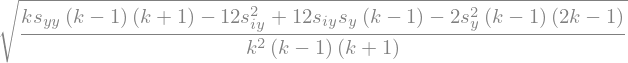

In [23]:
fit_rmse = sqrt(sum_of_squared_residuals / k)
display(fit_rmse)

In [24]:
def multiply_both_sides(expr, mul):
    return expr.func(expr.lhs * mul, expr.rhs * mul).simplify()
def add_to_both_sides(expr, add):
    return expr.func(expr.lhs + add, expr.rhs + add).simplify()
def apply_both_sides(expr, fun):
    return expr.func(fun(expr.lhs), fun(expr.rhs)).simplify()
def rel_to_zero(expr):
    return expr.func(expr.lhs - expr.rhs, 0)

The actual condition; keep contracting the window while this is true:

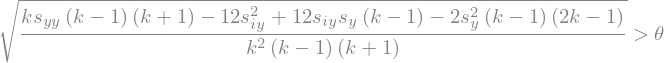

In [25]:
high_residuals_condition = fit_rmse > theta
high_residuals_condition

In [26]:
fit_rmse.subs({k: 2, s_y: 11, s_yy: 121, s_iy: 0})

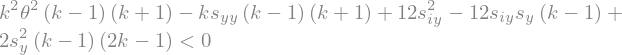

In [27]:
apply_both_sides(
    rel_to_zero(
        multiply_both_sides(
            apply_both_sides(
                high_residuals_condition,
                lambda expr: expr**2
            ),
            k * k * (k - 1) * (k + 1)
        )
    ).expand(),
    lambda expr: factor_subexpressions(expr, k)
)

## Value ranges

In [28]:
def bits(x):
    return math.floor(math.log2(x) + 1)

In [29]:
encoder_tick = (40e-3 * pi / (14 * 2 * 30)).evalf()
encoder_tick * 1e3

Maximum speed [m/s]:

In [30]:
max_speed = 1.5

Maximum speed in encoder ticks:

In [31]:
max_speed_raw = math.ceil(max_speed / encoder_tick)
max_speed_raw

In [32]:
max_window_size = 16

Number of bits needed for sum of velocities:

In [33]:
max_s_y = max_window_size * max_speed_raw
bits(max_s_y)

Number of bits needed for the sum of squared velocities:

In [34]:
max_s_yy = max_window_size * max_speed_raw**2
bits(max_s_yy)

Number of bits needed for the index sum:

In [35]:
max_s_iy = Sum(i * max_speed_raw, (i, 0, max_window_size - 1)).evalf()
bits(max_s_iy)

Scaling:

In [36]:
velocity_scale = 1 << 9
acceleration_scale = 1 << 10

Velocity fraction numerator:

In [37]:
def max_sum_thing(expr):
    expr = (
        expr
        .subs(substitutions)
        .simplify()
    )
    
    #return expr
    
    a = Wild("a")
    b = Wild("b")
    
    return expr \
        .replace(a * y(b), abs(a) * y(b)) \
        .subs(y(i), max_speed_raw) \
        .subs(k, max_window_size) \
        .evalf()

In [38]:
bits(velocity_scale * max_sum_thing(2 * max_window_size * s_y - s_y - 3 * s_iy))

Acceleration fraction numerator:

In [39]:
bits(acceleration_scale * max_sum_thing(max_window_size * s_y - s_y - 2 * s_iy))

Speed resolution @ 100Hz sample rate [$mm/$]:

In [40]:
1e3 * encoder_tick * 100 / velocity_scale

Velocity resolution @ 100Hz sample rate [$mm/s^2$]

In [41]:
1e3 * encoder_tick * 100**2 / acceleration_scale

## Plotting from CSV

In [42]:
# Raw velocity, smoothed velocity, smoothed acceleration, smoothing window size
# Alternating left and right motor
data = r"""-1,-116,-22,16
0,0,0,16
0,-105,-19,16
0,0,0,16
0,-94,-16,16
0,0,0,16
0,-82,-13,16
0,0,0,16
0,-71,-10,16
0,0,0,16
0,-60,-7,16
0,0,0,16
0,-48,-4,16
0,0,0,16
0,-37,-1,16
0,0,0,16
-1,-143,-21,16
0,0,0,16
0,-120,-15,16
0,0,0,16
-1,-214,-31,16
0,0,0,16
0,-180,-22,16
0,0,0,16
0,-146,-13,16
0,0,0,16
0,-112,-4,16
0,0,0,16
0,-79,5,16
0,0,0,16
0,-45,14,16
0,0,0,16
0,-75,-3,16
0,0,0,16
0,-52,3,16
0,0,0,16
0,-30,9,16
0,0,0,16
0,-7,15,16
0,0,0,16
3,1536,3072,2
0,0,0,16
10,5120,7168,2
0,0,0,16
22,11264,12288,2
0,0,0,16
36,18261,13312,3
0,0,0,16
51,26027,14848,3
0,0,0,16
70,35840,19456,2
0,0,0,16
74,37888,4096,2
0,0,0,16
72,36864,-2048,2
0,0,0,16
70,35840,-2048,3
0,0,0,16
68,34816,-2048,4
0,0,0,16
66,33792,-2048,5
0,0,0,16
64,32768,-2048,6
0,0,0,16
62,31744,-2048,7
0,0,0,16
61,30933,-1962,8
0,0,0,16
59,30049,-1928,9
0,0,0,16
58,29296,-1861,10
0,0,0,16
55,28300,-1880,11
0,0,0,16
54,27445,-1858,12
0,0,0,16
53,26686,-1817,13
0,0,0,16
51,25863,-1798,14
0,0,0,16
49,24994,-1792,15
0,0,0,16
48,24260,-1748,15
0,0,0,16
47,23599,-1693,15
0,0,0,16
45,22818,-1680,16
0,0,0,16
44,22155,-1635,16
0,0,0,16
42,21425,-1608,16
0,0,0,16
40,20627,-1599,16
0,0,0,16
39,19878,-1585,16
0,0,0,16
37,19049,-1593,16
0,0,0,16
35,18206,-1596,16
0,0,0,16
34,17412,-1594,16
0,0,0,16
33,16719,-1566,16
0,0,0,16
31,15883,-1584,16
0,0,0,16
30,15138,-1578,16
0,0,0,16
29,14483,-1548,16
0,0,0,16
27,13737,-1542,16
0,0,0,16
26,13018,-1537,16
0,0,0,16
24,12262,-1534,16
0,0,0,16
23,11595,-1507,16
0,0,0,16
22,10955,-1481,16
0,0,0,16
21,10394,-1435,16
0,0,0,16
19,9732,-1415,16
0,0,0,16
18,9084,-1400,16
0,0,0,16
17,8504,-1367,16
0,0,0,16
16,7928,-1341,16
0,0,0,16
14,7228,-1349,16
0,0,0,16
13,6584,-1341,16
0,0,0,16
12,5997,-1319,16
0,0,0,16
11,5402,-1307,16
0,0,0,16
10,4853,-1283,16
0,0,0,16
8,4232,-1269,16
0,0,0,16
7,3603,-1266,16
0,0,0,16
6,3019,-1251,16
0,0,0,16
4,2300,-1272,16
0,0,0,16
4,1743,-1258,16
0,0,0,16
2,1103,-1258,16
0,0,0,16
1,508,-1246,16
0,0,0,16
0,-105,-1248,16
0,0,0,16
0,-568,-1218,16
0,0,0,16
0,-204,-512,5
0,0,0,16
0,-219,-380,6
0,0,0,16
0,-219,-292,7
0,0,0,16
0,-213,-231,8
0,0,0,16
0,-204,-187,9
0,0,0,16
0,-195,-155,10
0,0,0,16
0,-186,-130,11
0,0,0,16
0,-177,-110,12
0,0,0,16
0,-168,-95,13
0,0,0,16
0,-160,-83,14
0,0,0,16
0,-153,-73,15
0,0,0,16
0,-146,-64,16
0,0,0,16
0,-52,-22,16
"""

In [43]:
data_np = numpy.genfromtxt(io.StringIO(data), delimiter=",", dtype=numpy.int32)[::2]
data_np

array([[   -1,  -116,   -22,    16],
       [    0,  -105,   -19,    16],
       [    0,   -94,   -16,    16],
       [    0,   -82,   -13,    16],
       [    0,   -71,   -10,    16],
       [    0,   -60,    -7,    16],
       [    0,   -48,    -4,    16],
       [    0,   -37,    -1,    16],
       [   -1,  -143,   -21,    16],
       [    0,  -120,   -15,    16],
       [   -1,  -214,   -31,    16],
       [    0,  -180,   -22,    16],
       [    0,  -146,   -13,    16],
       [    0,  -112,    -4,    16],
       [    0,   -79,     5,    16],
       [    0,   -45,    14,    16],
       [    0,   -75,    -3,    16],
       [    0,   -52,     3,    16],
       [    0,   -30,     9,    16],
       [    0,    -7,    15,    16],
       [    3,  1536,  3072,     2],
       [   10,  5120,  7168,     2],
       [   22, 11264, 12288,     2],
       [   36, 18261, 13312,     3],
       [   51, 26027, 14848,     3],
       [   70, 35840, 19456,     2],
       [   74, 37888,  4096,     2],
 

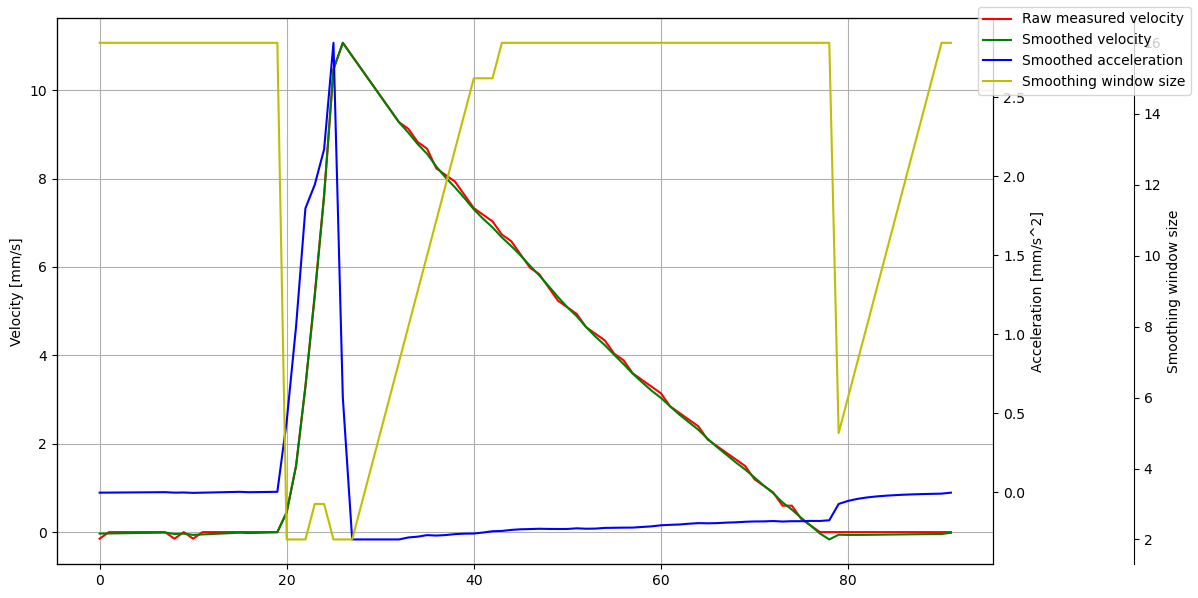

In [44]:
fig, ax1 = plt.subplots()

ax1.plot(data_np[:,0] * 1e3 * encoder_tick, "r-", label="Raw measured velocity")
ax1.plot(data_np[:,1] * 1e3 * encoder_tick / velocity_scale, "g-", label="Smoothed velocity")
ax1.grid()
ax1.set(ylabel="Velocity [mm/s]")

ax2 = ax1.twinx()
ax2.plot(data_np[:,2] * 1e3 * encoder_tick / acceleration_scale, "b-", label="Smoothed acceleration")
ax2.set(ylabel="Acceleration [mm/s^2]")

ax3 = ax1.twinx()
ax3.spines.right.set_position(("axes", 1.15))
ax3.plot(data_np[:,3], "y-", label="Smoothing window size")
ax3.set(ylabel="Smoothing window size")

fig.tight_layout()
fig.legend()

plt.show()